In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
# Read the dataset into a data frame
df = pd.read_excel('nyc_crime2013.xls', skiprows=4)
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [3]:
# Create a data frame with only the features of interest
pc_df = df[['City', 'Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Property\ncrime']].copy()
pc_df.rename(columns={'Property\ncrime': 'PropertyCrime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder'}, inplace=True)
pc_df.head()

,City,Population,Murder,Robbery,PropertyCrime
0,Adams Village,1861.0,0.0,0.0,12.0
1,Addison Town and Village,2577.0,0.0,0.0,24.0
2,Akron Village,2846.0,0.0,0.0,16.0
3,Albany,97956.0,8.0,227.0,4090.0
4,Albion Village,6388.0,0.0,4.0,223.0


In [4]:
# Determine if there are null values
pc_df.isna().sum()

City             0
Population       3
Murder           3
Robbery          3
PropertyCrime    3
dtype: int64

In [5]:
# Drop the information rows at the end of the dataset
pc_df.dropna(how='any', inplace=True)
pc_df.describe()

,Population,Murder,Robbery,PropertyCrime
count,3.480000e+02,348.000000,348.000000,348.000000
mean,4.003763e+04,1.566092,72.902299,792.606322
std,4.500374e+05,18.303673,1031.032873,7659.724746
min,5.260000e+02,0.000000,0.000000,0.000000
25%,3.003000e+03,0.000000,0.000000,40.500000
50%,7.233500e+03,0.000000,1.000000,112.500000
75%,1.842750e+04,0.000000,5.000000,341.000000
max,8.396126e+06,335.000000,19170.000000,141971.000000


In [6]:
# Find the amomalous robbery cities
robbery_anomaly = pc_df['Robbery'].mean() + (2 * np.std(pc_df['Robbery'])) 
pc_df.loc[pc_df['Robbery'] > robbery_anomaly]

,City,Population,Murder,Robbery,PropertyCrime
216,New York,8396126.0,335.0,19170.0,141971.0


In [7]:
# Find the anomalous murder cities
m_anomaly = pc_df['Murder'].mean() + (2 * np.std(pc_df['Murder'])) 
big_cities = pc_df.loc[pc_df['Murder'] > m_anomaly]

In [8]:
# Drop the anomalous big cities because of the outsized effect they would have on the model
# These big cities might be better suited with a comparison of other large urban areas across the nation
pc_df.drop(big_cities.index, inplace=True)
pc_df.describe()

,Population,Murder,Robbery,PropertyCrime
count,345.000000,345.000000,345.000000,345.000000
mean,14688.750725,0.350725,11.478261,322.649275
std,21318.571420,1.587160,41.615561,612.050221
min,526.000000,0.000000,0.000000,0.000000
25%,2985.000000,0.000000,0.000000,39.000000
50%,7112.000000,0.000000,1.000000,112.000000
75%,17965.000000,0.000000,5.000000,337.000000
max,199134.000000,21.000000,400.000000,6473.000000


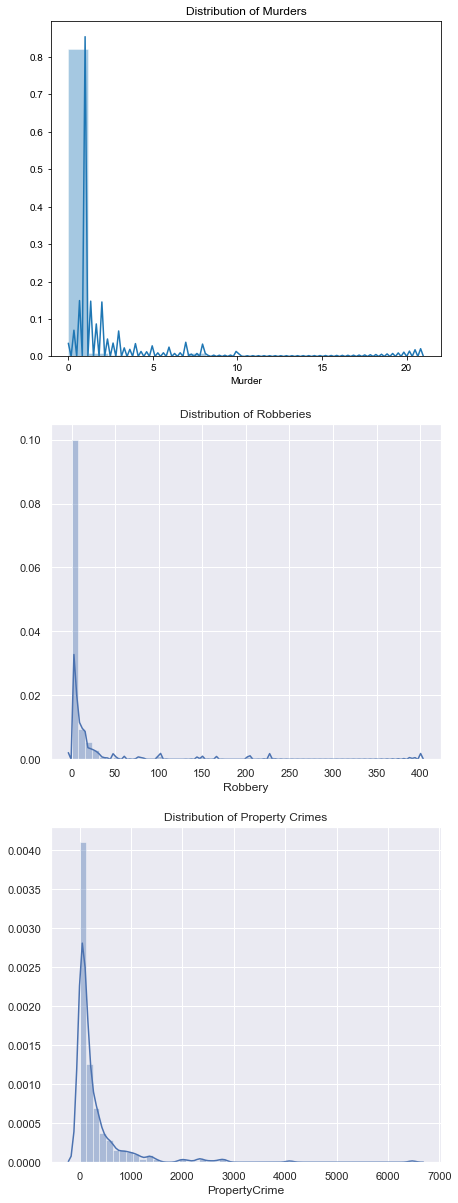

In [9]:
# Check the distribution  of Murder
plt.figure(figsize=(7, 21))

plt.subplot(3,1,1)
sns.set()
sns.distplot(pc_df['Murder'])
plt.title('Distribution of Murders')

# Check the distribution of Robbery
plt.subplot(3,1,2)
sns.distplot(pc_df['Robbery'])
plt.title('Distribution of Robberies')

# Check the distribution of property crime
plt.subplot(3,1,3)
sns.distplot(pc_df['PropertyCrime'])
plt.title('Distribution of Property Crimes')
plt.show()

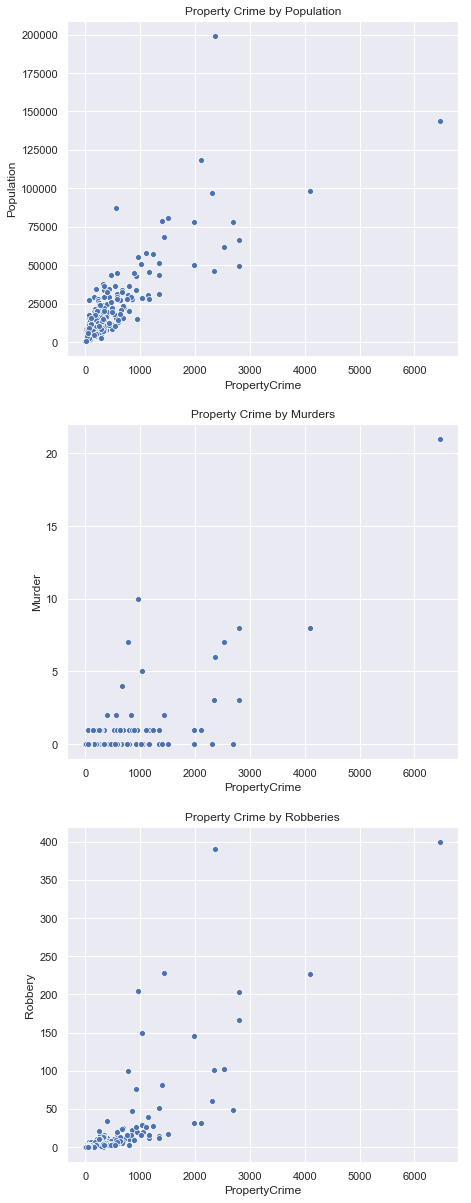

In [10]:
plt.figure(figsize=(7, 21))

plt.subplot(3,1,1)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Population'])
plt.title('Property Crime by Population')

plt.subplot(3,1,2)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Murder'])
plt.title('Property Crime by Murders')

plt.subplot(3,1,3)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Robbery'])
plt.title('Property Crime by Robberies')
plt.show()

In [11]:
#Create features for population squared and for the categorical versions murder and robbery
pc_df['Murder'] = pc_df['Murder'].apply(lambda x:  1 if x>0 else 0)
pc_df['Robbery'] = np.sqrt(pc_df['Robbery'])

pc_df.head()

,City,Population,Murder,Robbery,PropertyCrime
0,Adams Village,1861.0,0,0.000000,12.0
1,Addison Town and Village,2577.0,0,0.000000,24.0
2,Akron Village,2846.0,0,0.000000,16.0
3,Albany,97956.0,1,15.066519,4090.0
4,Albion Village,6388.0,0,2.000000,223.0


In [12]:
# Build regression model 
from sklearn.linear_model import LinearRegression
X = pc_df[['Murder', 'Population', 'Robbery']]
Y = pc_df['PropertyCrime']
regr = LinearRegression().fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-3.23536749e+01  1.16339066e-02  1.14549404e+02]

Intercept: 
 -49.38411561123564

R-squared:
0.7921855181811697


##  Feature Engineering and Model Performance
The features requested in the previous exercises included some outliers. I found the outliers by taking anything greater than 2 standard deviations from the mean in murders and robberies and dropped them. The model would lose predictive capability for smaller cities if the dense urban centers were included in the data. The relationship between each of the features and the outcome variable was not linear, so I performed some transformations. I looked at the plots and applied a square root to the to the robberies to get closer to linear, but I did not see any way of getting the murders relationship to property crime close to linear, so I used the suggestion of one-hot encoding them. 

The R-Squared scored seemed to be relatively high, but the predictions were way off. This could be attributed to the fact that there is not a linear relationship between the way crime grows from small cities to large cities. There is also a factor of density missing, which I think would help explain the property crime even better. Socio-economic distribution in the city could also be more predictive of property crime.

Using just the data set given, the model is more closely predictive when set up per the previous exercise (murder and robbery one-hot encoded and population squared added as a feature). It might be worth trimming the tails even a bit more than just those greater than 2 standard deviations from the mean. I could also try normalizing the outcome variable.

## Model Validation and Iteration
It's time to T-test the features in this model and try to get some features that are more descriptive of variance in the outcome variable.

In [13]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [14]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Murder'
lm = smf.ols(formula=linear_formula, data=pc_df).fit()

In [15]:
lm.params

Intercept     -49.384116
Population      0.011634
Robbery       114.549404
Murder        -32.353675
dtype: float64

In [16]:
lm.pvalues

Intercept     7.637093e-03
Population    4.289424e-19
Robbery       4.719844e-27
Murder        5.567046e-01
dtype: float64

In [17]:
pc_df['PopSq'] = pc_df['Population'].apply(lambda x: x**2)

In [18]:
linear_formula = 'PropertyCrime ~ Population+Robbery+PopSq'
lm = smf.ols(formula=linear_formula, data=pc_df).fit()

In [19]:
lm.params

Intercept    -7.289137e+01
Population    1.460542e-02
Robbery       1.099388e+02
PopSq        -2.419493e-08
dtype: float64

In [20]:
lm.pvalues

Intercept     6.592686e-04
Population    3.051144e-14
Robbery       3.025071e-28
PopSq         3.032686e-02
dtype: float64

In [21]:
lm.rsquared

0.7948206457470758

In [26]:
pc_df = pc_df.merge(df[['City','Violent\ncrime']])
pc_df.rename(columns={'Violent\ncrime': 'ViolentCrime'}, inplace=True)
pc_df.head()

,City,Population,Murder,Robbery,PropertyCrime,PopSq,ViolentCrime
0,Adams Village,1861.0,0,0.000000,12.0,3.463321e+06,0.0
1,Addison Town and Village,2577.0,0,0.000000,24.0,6.640929e+06,3.0
2,Akron Village,2846.0,0,0.000000,16.0,8.099716e+06,3.0
3,Albany,97956.0,1,15.066519,4090.0,9.595378e+09,791.0
4,Albion Village,6388.0,0,2.000000,223.0,4.080654e+07,23.0


In [27]:
linear_formula = 'PropertyCrime ~ Population+Robbery+PopSq+ViolentCrime'
lm = smf.ols(formula=linear_formula, data=pc_df).fit()

In [28]:
lm.params

Intercept      -4.691044e+01
Population      2.440622e-02
Robbery        -2.290519e+01
PopSq          -1.151106e-07
ViolentCrime    3.588847e+00
dtype: float64

In [29]:
lm.pvalues

Intercept       1.040736e-02
Population      4.127328e-34
Robbery         1.027525e-01
PopSq           1.888754e-18
ViolentCrime    1.099704e-25
dtype: float64

In [30]:
lm.rsquared

0.8515029323584785

In [31]:
linear_formula = 'PropertyCrime ~ Population+PopSq+ViolentCrime'
lm = smf.ols(formula=linear_formula, data=pc_df).fit()

In [32]:
lm.pvalues

Intercept       6.001342e-03
Population      7.560472e-50
PopSq           8.237886e-22
ViolentCrime    1.037154e-51
dtype: float64

In [33]:
lm.rsquared

0.8503338717382204

After some iteration with the different features available in this dataset, I found the set that provides the most unique description of the variance in the outcome variable to be the population, population squared, and violent crime. Through the various t-tests and f-tests, I was able to winnow out murders and robberies as unhelpful features because of their p-values from the t-tests. The r squared from the f-tests also increased over the iterations to 0.85.